# Hidden markov model (HMM)

We show how contact duration, passage time and frequencies depend on the distance between ctcf sites. We consider only the best set of parameters in the presence of extruders and barriers. We calculate the model for 150kb and apply it to all other setups.

In [19]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from hmmlearn import hmm
from matplotlib.backends.backend_pdf import PdfPages
from utils import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import glob
import pathlib
import gdown
import os
import zipfile
import matplotlib
import matplotlib.colors as mcolors
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
reproducible = True
distance_conversion = (0.012*np.sqrt(40)) # 1 a.u. = 0.08 um
rolling = 1
if reproducible:
    seed=42
    np.random.seed(seed)
subsample = False

if subsample:
    number_subsample = 200000

# Reading simulated data

In [4]:
dataset_name = "tad_sizes"
basedir = f"./{dataset_name}/"
#create a folder
pathlib.Path(basedir).mkdir(parents=True, exist_ok=True)
#basedir = "/tungstenfs/scratch/ggiorget/pavel/code_projects/systematic_chrodyn_simulations/langevin_simulations/analysis_sweep/revision1/diff_tads/"
sample_link = "https://drive.google.com/uc?export=download&id=1hnxHHv08_yVkWxMPXyt6PCeJpxja75p9"
# download data if not already present
if not os.path.isfile(basedir+f"{dataset_name}.zip"):
    gdown.download(sample_link, basedir+f"{dataset_name}.zip")
#unzip the data
with zipfile.ZipFile(basedir+f"{dataset_name}.zip", 'r') as zip_ref:
    zip_ref.extractall(basedir)
list_files = glob.glob(f"{basedir}/diff_tads_data/*/*/*/*/*/*/dst_bnd.dat")

filenames = pd.DataFrame(list_files, columns=["filename"])
filenames[["tad_size", "ctcf", "speed", "loading", "unloading", "rep"]] = filenames[
    "filename"
].str.extract(
    r"diff_tads_data\/([\d+]*)\/([\w+]*)\/([\d+]*)\/([\d]\.[\d+]*)\/([\d]\.[\d+]*)\/([\d+]*)\/",
    expand=True,
)
conversion_kb_to_beads = {"100":"12", "150":"18", "250":"29", "500":"61", "1000":"123"}
conversion_beads_to_kb = {"12":100, "18":150, "29":250, "61":500, "123":1000}
conversion_beads_to_kb_int = {int(k):int(v) for k,v in conversion_beads_to_kb.items()}
filenames=filenames.replace({"tad_size": conversion_kb_to_beads})

filenames["condition"] = (
    filenames["tad_size"] + '_' + filenames["speed"] + "." + filenames["loading"] + "_" + filenames["unloading"]
)
filenames["uniqueid"] = (
    filenames["tad_size"]
    + '_'
    + "ctcf"
    + filenames["ctcf"]
    + "."
    + "rad21"
    + "on"
    + "_"
    + filenames["speed"]
    + "."
    + filenames["loading"]
    + "."
    + filenames["unloading"]
    + "."
    + filenames["rep"]
)

Downloading...
From: https://drive.google.com/uc?export=download&id=1hnxHHv08_yVkWxMPXyt6PCeJpxja75p9
To: /tungstenfs/scratch/ggiorget/pavel/code_projects/systematic_chrodyn_simulations/langevin_simulations/analysis_sweep/revision1/diff_tads/test_notebooks/SPT_analysis/notebooks/tad_sizes/tad_sizes.zip
100%|██████████████████████████████████████████████████████████████████████████| 275M/275M [00:51<00:00, 5.32MB/s]


In [5]:
all_tad_sizes_dataset_orig = []
for tad_size, sub3 in filenames.groupby('tad_size'):
    alldf = []
    for condition, sub2 in sub3.groupby('condition'):
        for uniqueid, sub1 in sub2.groupby('uniqueid'):
            for ct, sub in sub1.groupby('ctcf'):
                for file in sub.filename.unique():
                    tmp = pd.read_csv(file, sep=" ")
                    tmp.distance = tmp.distance * distance_conversion
                    try:
                        tmp.drop(["x1", "y1", "z1", "x2", "y2", "z2"], axis =1, inplace=True)
                    except:
                        pass
                    tmp['tad_size'] = tad_size
                    tmp['condition'] = condition
                    tmp['frame'] = np.arange(len(tmp))
                    tmp['uniqueid'] = uniqueid 
                    tmp['ctcf'] = ct
                    tmp['rad21'] = "on"
                    if subsample:
                        tmp = tmp.head(number_subsample)
    #                 distances_original = pd.concat([distances_original, tmp])
                    alldf.append(tmp)
    distances_original = pd.concat(alldf)
    all_tad_sizes_dataset_orig.append(distances_original)

# Subsampling  to 30s and training 2 state hmm

In [6]:
# choose neighbors
nneighbor = 2
subsample_every = 30
all_tad_sizes_dataset = []
idx = []
for distances in all_tad_sizes_dataset_orig:
    tad_size = int(distances.tad_size.unique()[0])
    idx = (
        np.where(
            np.array([abs(eval(x)) for x in distances.columns[1:][:-7]]) >= tad_size - nneighbor
        )[0]
        + 1
    )
    distances["bond"] = distances.iloc[:, idx].sum(axis=1)
    distances.loc[distances["bond"] > 1, "bond"] = 1

    distances = distances.iloc[::subsample_every].copy()
    distances.bond = 1 - distances.bond.values
    distances_nonoise = distances.copy()
    # add experimental noise
    seed = 0
    np.random.seed(seed)
    distances.distance = distances.distance.values + np.random.normal(
        loc=0.0, scale=0.064, size=len(distances)
    )
    distances.frame = distances.frame.values / subsample_every
    all_tad_sizes_dataset.append(distances)

In [7]:
# run HMM training on all conditions
results = {}
np.random.seed(seed)
for distances in all_tad_sizes_dataset:
    for condition, sub in distances.groupby("condition"):
        traj2d = np.reshape(
            sub[sub.ctcf == "on"].distance.to_numpy(),
            (-1, 1),
        )
#        model = hmm.GaussianHMM(
#            n_components=2,
#            covariance_type="full",
#            min_covar=0.1,
#            n_iter=10000,
#            params="mtc",
#            init_params="mtc",
#            hack=True,
#            hack_mean=0.15507389,
#            hack_covar=0.00775845,
#        )
        #print(model.covariance_type)
        model = hmm.GaussianHMM(
            n_components=2,
            covariance_type="full",
            min_covar=0.1,
            n_iter=10000,
            params="t",
            init_params="t",
        )
        model.means_ = [[0.17922608], [0.43435689]] # 18 beads
        #[[0.15507389], [0.39257526]] # 12 beads
                        
        model.covars_ = [[[0.00921505]], [[0.01828777]]] # 18 beads
        #[[[0.00775845]], [[0.01408439]]] # 12 beads
                        

        # instead of fitting
        model.startprob_ = [0.5, 0.5]
        model.fit(traj2d)

        results[condition] = model
models2hmm = results.copy()

In [8]:
# reorder HMM model such that the first gaussian is always the lowest
for key, model in results.items():
    newmodel = reorder_hmm_model_parameters(model)
    model = newmodel
    means = (model.means_)
    sigmas = np.sqrt(model.covars_.squeeze())
    w = np.array(model.transmat_)
    logProb = model.score(traj2d)
    print(f"tad-ctcf-speed-loading-unloading = {key}")
    print(f"Gaussian means: {means}")
    print(f"Gaussian std: {sigmas}")
    print(f"Gaussian covars_ {model.covars_}")
    print(f"Transition rates: {w}")
    print("----------\n")

tad-ctcf-speed-loading-unloading = 12_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.01828777]]]
Transition rates: [[0.96219416 0.03780584]
 [0.06083393 0.93916607]]
----------

tad-ctcf-speed-loading-unloading = 123_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.01828777]]]
Transition rates: [[7.07232977e-01 2.92767023e-01]
 [2.19453991e-09 9.99999998e-01]]
----------

tad-ctcf-speed-loading-unloading = 18_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.01828777]]]
Transition rates: [[0.96122776 0.03877224]
 [0.04823642 0.95176358]]
----------

tad-ctcf-speed-loading-unloading = 29_17500.0.05_0.01
Gaussian means: [[0.17922608]
 [0.43435689]]
Gaussian std: [0.09599505 0.13523228]
Gaussian covars_ [[[0.00921505]]

 [[0.

# Reading experimental data

In [9]:
dataset = "211221_two_colors_distance_30s.csv"
basedir = f"./{dataset}/"
#create a folder
pathlib.Path(basedir).mkdir(parents=True, exist_ok=True)
sample_link = "https://drive.google.com/uc?export=download&id=1szF0P4OcA0X8WoPha5CKjo0sCLhJnrtX"
if not os.path.isfile(f"{basedir}{dataset}.zip"):
    gdown.download(sample_link, f"{basedir}{dataset}.zip")
#unzip the data
with zipfile.ZipFile(f"{basedir}{dataset}.zip", 'r') as zip_ref:
    zip_ref.extractall(basedir)
    
list_cell_lines = ["1A2", "1B1"]
bins = np.arange(30, 10000, 150)

#download pretrained hmm model
gdown.download(
    "https://drive.google.com/uc?export=download&id=1oGTB_Ml4RQpwCeHackjYd2Tc_MDd6sqm", 
    f"{basedir}hmmmodel_two_colors_distance_30s.obj",
)
with open(f"{basedir}/hmmmodel_two_colors_distance_30s.obj", "rb") as f:
    exp_model = pickle.load(f)

exp = pd.read_csv(f"{basedir}{dataset}")
exp = exp[exp.cell_line.isin(list_cell_lines)]
exp["condition"] = exp["cell_line"] + "_" + exp["induction_time"]

hue_order = sorted(exp["condition"].unique())
(
    exp_durations,
    exp_second_passage_times,
    exp_frequencies,
    exp_fraction_time,
    exp_conditions,
    exp_data_filtered,
) = calculate_duration_second_passage_time_diff_tads(
    data=exp,
    resolution=30,
    model=exp_model,
    fraction_nan_max=0.2,
)

Downloading...
From: https://drive.google.com/uc?export=download&id=1oGTB_Ml4RQpwCeHackjYd2Tc_MDd6sqm
To: /tungstenfs/scratch/ggiorget/pavel/code_projects/systematic_chrodyn_simulations/langevin_simulations/analysis_sweep/revision1/diff_tads/test_notebooks/SPT_analysis/notebooks/211221_two_colors_distance_30s.csv/hmmmodel_two_colors_distance_30s.obj
100%|████████████████████████████████████████████████████████████████████████| 1.46k/1.46k [00:00<00:00, 6.55MB/s]


In [10]:
1- exp_data_filtered.groupby("condition").prediction.mean()

condition
1A2_0min      0.300186
1A2_120min    0.071965
1B1_0min      0.780381
1B1_120min    0.176872
Name: prediction, dtype: float64

### calculate the mean contact duration and second passage time across all parameters

In [11]:
mean = pd.DataFrame()
alldata = pd.DataFrame()
sim_duration_distributions = pd.DataFrame()
for distances in all_tad_sizes_dataset:
    for cond, distances_selected in distances.groupby("condition"):
        distances_selected.condition = distances_selected.uniqueid.map(
            lambda x: str(x)[:-2]
        )
        distances_selected.condition = distances_selected.uniqueid
        (
            durations,
            second_passage_times,
            frequencies,
            fraction_time,
            conditions,
            data,
        ) = calculate_duration_second_passage_time_diff_tads(
            distances_selected,
            resolution=30,
            model=results[cond],
            tad_size_flag=True,
        )
        print(cond)
        # if len(durations) == 0:
        tmp = pd.DataFrame(
            durations.groupby("cell_line").mean()["contact_duration"]
        ).reset_index()
        tmp["second_passage_time"] = (
            second_passage_times.groupby("cell_line")
            .mean()["second_passage_time"]
            .values
        )
        tmp["frequency"] = (
            1 / (frequencies.groupby("cell_line").mean()["frequency"].values) * 1000
        )
        tmp["condition"] = cond
        mean = pd.concat([mean, tmp])
        alldata = pd.concat([data, alldata])

    mean[["tad_size", "speed", "loading", "unloading"]] = mean["condition"].str.extract(
        r"([\d+]*)_([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True
    )
    mean["ctcf"] = mean["cell_line"]

12_17500.0.05_0.01
123_17500.0.05_0.01
18_17500.0.05_0.01
29_17500.0.05_0.01
61_17500.0.05_0.01


### Extracting gaussian means of HMM model from simulated data

In [12]:
gaussian_means = pd.DataFrame()

for key, model in results.items():
    tmp = pd.DataFrame(model.means_, columns=["gaussian_means"])
    tmp["state"] = ["looped", "unlooped"]
    tmp["condition"] = key
    gaussian_means = pd.concat([gaussian_means, tmp])
gaussian_means[["tad_size", "speed", "loading", "unloading"]] = gaussian_means[
    "condition"
].str.extract(r"([\d+]*)_([\d+]*)\.([\d]\.[\d+]*)_([\d]\.[\d+]*)", expand=True)

### calculate distance of gaussian means between simulation and experiments

In [13]:
dist_gaussian_means_looped = gaussian_means[["gaussian_means", "condition"]][
    gaussian_means.state == "looped"
]
dist_gaussian_means_unlooped = gaussian_means[["gaussian_means", "condition"]][
    gaussian_means.state == "unlooped"
]
dist_gaussian_means_looped["gaussian_means"] = (
    np.abs(dist_gaussian_means_looped["gaussian_means"].values - 0.1493922) / 0.1493922
)
dist_gaussian_means_unlooped["gaussian_means"] = (
    np.abs(dist_gaussian_means_unlooped["gaussian_means"].values - 0.28807371)
    / 0.28807371
)

dist_gaussian_means = pd.merge(
    dist_gaussian_means_looped, dist_gaussian_means_unlooped, on="condition"
)
# since we want to keep only the looped state, I could have done this more easily
dist_gaussian_means[
    "dist_gaussian_means"
] = dist_gaussian_means.gaussian_means_x  # + dist_gaussian_means.gaussian_means_y

### Plot Gaussian mean as heatmap

posx and posy should be finite values
posx and posy should be finite values


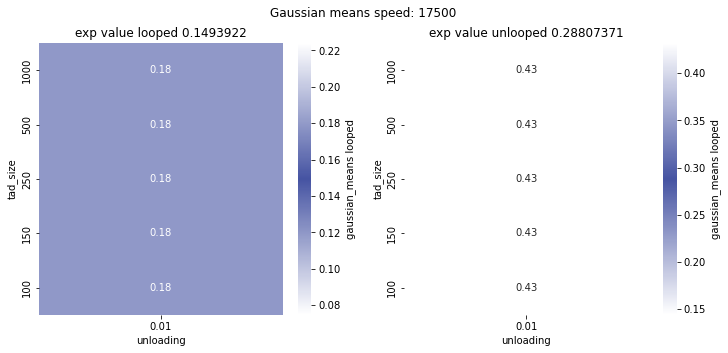

In [14]:
pdf = PdfPages(f"/tungstenfs/scratch/ggiorget/pavel/code_projects/systematic_chrodyn_simulations/langevin_simulations/analysis_sweep/revision1/diff_tads/{dataset_name}_2states_HMM_neighbor_{nneighbor}.pdf")

speed = "17500"
exp_looped = 0.1493922
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [(1, 1, 1), (69 / 255, 83 / 255, 162 / 255), (1, 1, 1)]
)
norm = mcolors.TwoSlopeNorm(
    vmin=exp_looped * 0.5, vcenter=exp_looped, vmax=exp_looped * 1.5
)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
gaussian_means = gaussian_means.astype({"tad_size": "int32"})
sns.heatmap(
    gaussian_means[(gaussian_means.state == "looped") & (gaussian_means.speed == speed)]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "gaussian_means")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "gaussian_means looped"},
    norm=norm,
    ax=ax[0],
)
ax[0].set_title(f"exp value looped {exp_looped}")

exp_unlooped = 0.28807371
norm = mcolors.TwoSlopeNorm(
    vmin=exp_unlooped * 0.5, vcenter=exp_unlooped, vmax=exp_unlooped * 1.5
)

sns.heatmap(
    gaussian_means[
        (gaussian_means.state == "unlooped") & (gaussian_means.speed == speed)
    ]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "gaussian_means")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "gaussian_means looped"},
    norm=norm,
    ax=ax[1],
)
ax[1].set_title(f"exp value unlooped {exp_unlooped}")
plt.suptitle(f"Gaussian means speed: {speed}")
plt.show()
pdf.savefig(fig)

### Plot average first passage time

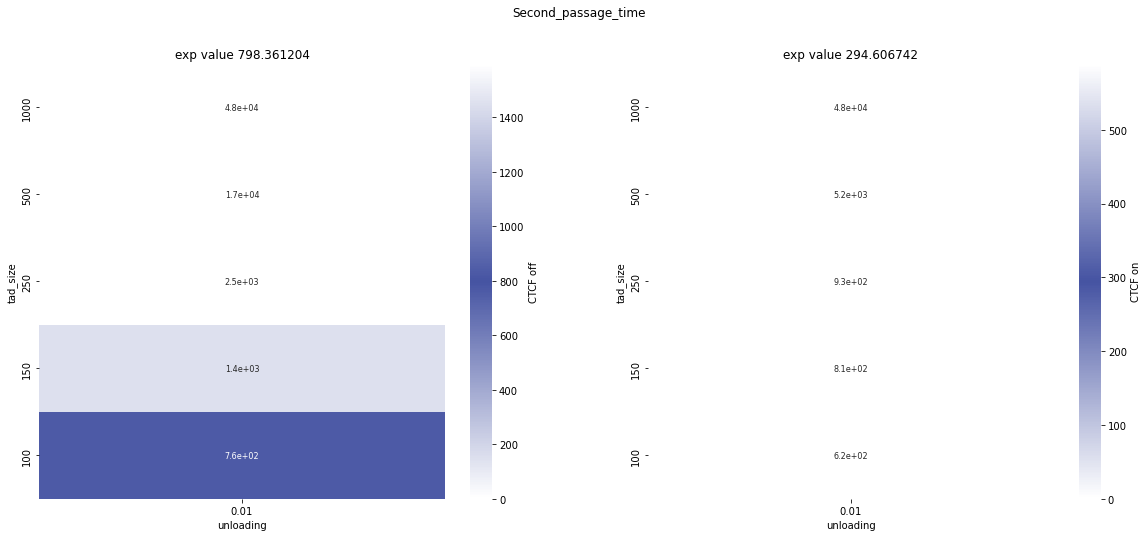

In [15]:
# ctcf_off = 420
speed = "17500"
ctcf_off = 798.361204
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off * 0, vcenter=ctcf_off, vmax=ctcf_off * 2)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
mean = mean.astype({"tad_size": "int32"})
sns.heatmap(
    mean[(mean.ctcf == "ctcfoff.rad21on") & (mean.speed == speed)]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "second_passage_time")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm=norm,
    annot_kws={"size": 8},
    ax=ax[0],
)
ax[0].set_title(f"exp value {ctcf_off}")

# ctcf_on = 150
ctcf_on = 294.606742
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on * 0, vcenter=ctcf_on, vmax=ctcf_on * 2)
sns.heatmap(
    mean[(mean.ctcf == "ctcfon.rad21on") & (mean.speed == speed)]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "second_passage_time")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm=norm,
    annot_kws={"size": 8},
    ax=ax[1],
)
ax[1].set_title(f"exp value {ctcf_on}")
plt.suptitle("Second_passage_time")
plt.show()
pdf.savefig(fig)

### Plot average contact duration

In [22]:
nneighbors = 3
tads = [12, 123, 18, 29, 61]
total_streaks = {}
for i in range(5):
    for ctcf, df in all_tad_sizes_dataset_orig[i].groupby('ctcf'):
        cols2sum = [x for x in df.columns[1:-7].values if abs(eval(x)+tads[i]) < nneighbors]
        df['contact'] = df[cols2sum].sum(axis=1)
        df.loc[df['contact'] > 0, 'contact'] = 1
        vals, _, lens = find_runs(df['contact'].values)
        total_streaks[str(tads[i])+ctcf] = lens[vals==1]

In [23]:
gt_data_2_plot = np.zeros((2,5,3))
for i,ctcf in enumerate(['on', 'off']):
    for j,tad in enumerate(sorted(tads)):
        gt_data_2_plot[i,j,0] = tad
        try:
            gt_data_2_plot[i,j,1] = np.mean(total_streaks[str(tad)+ctcf])
        except:
            gt_data_2_plot[i,j,1] = np.nan
        try:    
            gt_data_2_plot[i,j,2] = np.std(total_streaks[str(tad)+ctcf])
        except:
            gt_data_2_plot[i,j,2] = np.nan

/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home_fmi/01/kospave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


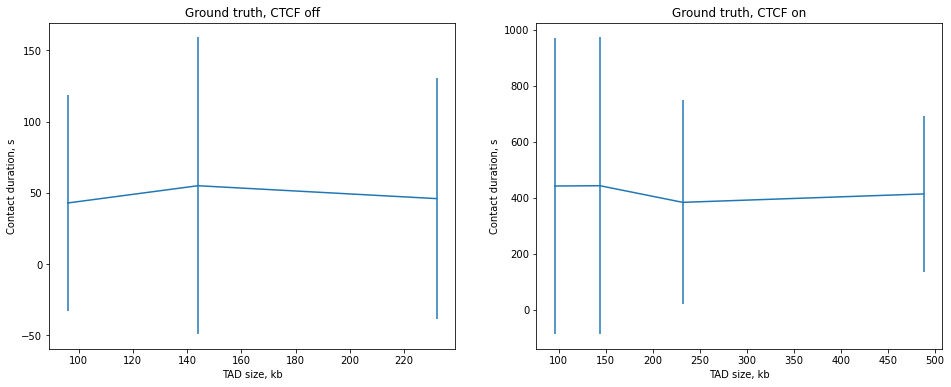

In [24]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
axs[1].errorbar(gt_data_2_plot[0,:,0]*8, gt_data_2_plot[0,:,1], yerr=gt_data_2_plot[0,:,2])
axs[1].set_title('Ground truth, CTCF on')
axs[1].set_xlabel('TAD size, kb')
axs[1].set_ylabel('Contact duration, s')
axs[0].errorbar(gt_data_2_plot[1,:,0]*8, gt_data_2_plot[1,:,1], yerr=gt_data_2_plot[1,:,2])
axs[0].set_title('Ground truth, CTCF off')
axs[0].set_xlabel('TAD size, kb')
axs[0].set_ylabel('Contact duration, s')
pdf.savefig(fig)

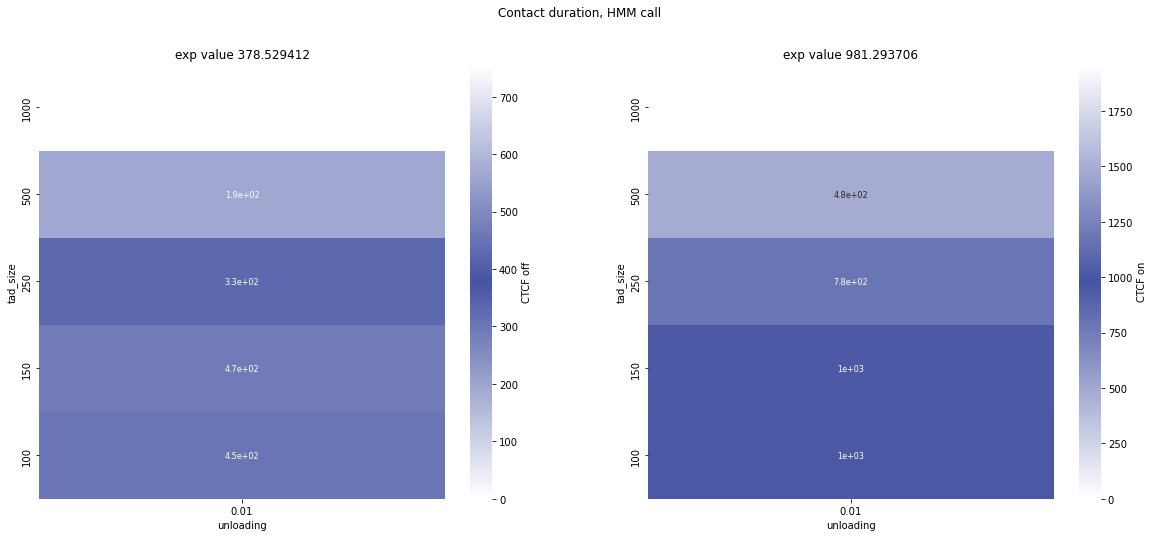

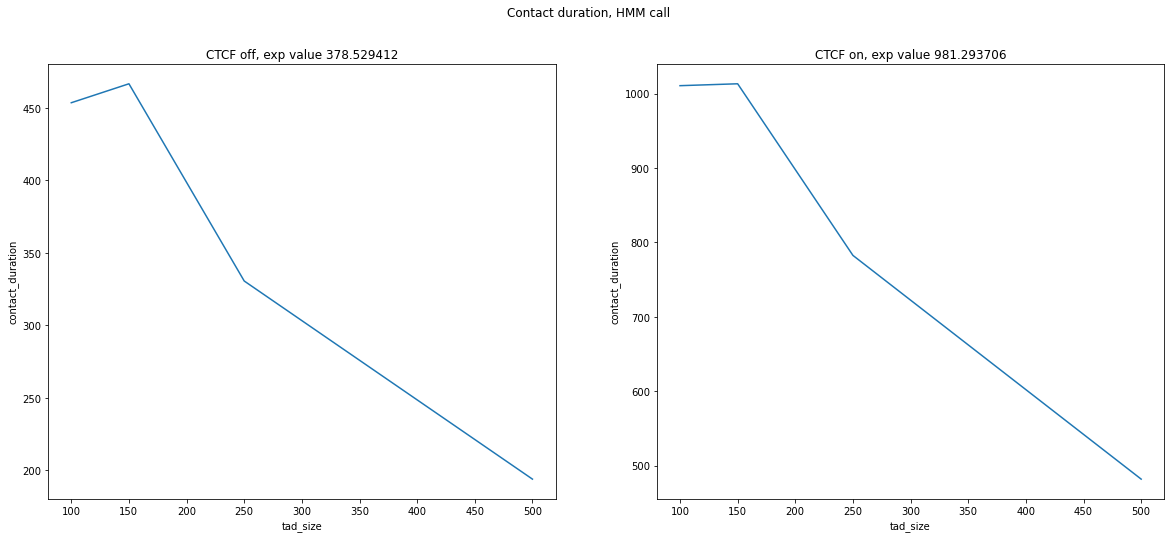

In [25]:
# ctcf_off = 270
speed = "17500"
ctcf_off = 378.529412
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off * 0, vcenter=ctcf_off, vmax=ctcf_off * 2)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
mean = mean.astype({"tad_size": "int32"})
sns.heatmap(
    mean[(mean.ctcf == "ctcfoff.rad21on") & (mean.speed == speed)]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "contact_duration")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm=norm,
    annot_kws={"size": 8},
    ax=ax[0],
)
ax[0].set_title(f"exp value {ctcf_off}")

# ctcf_on = 480
ctcf_on = 981.293706
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on * 0, vcenter=ctcf_on, vmax=ctcf_on * 2)
sns.heatmap(
    mean[(mean.ctcf == "ctcfon.rad21on") & (mean.speed == speed)]
    .replace({"tad_size": conversion_beads_to_kb_int})
    .pivot("tad_size", "unloading", "contact_duration")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm=norm,
    annot_kws={"size": 8},
    ax=ax[1],
)
ax[1].set_title(f"exp value {ctcf_on}")
plt.suptitle("Contact duration, HMM call")
plt.show()
pdf.savefig(fig)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(
    data=mean[(mean.ctcf == "ctcfoff.rad21on") & (mean.speed == speed)]
    .reset_index()
    .replace({"tad_size": conversion_beads_to_kb_int}),
    x="tad_size",
    y="contact_duration",
    ax=ax[0],
)
ax[0].set_title(f"CTCF off, exp value {ctcf_off}")
sns.lineplot(
    data=mean[(mean.ctcf == "ctcfon.rad21on") & (mean.speed == speed)]
    .reset_index()
    .replace({"tad_size": conversion_beads_to_kb_int}),
    x="tad_size",
    y="contact_duration",
    ax=ax[1],
)
ax[1].set_title(f"CTCF on, exp value {ctcf_on}")
plt.suptitle("Contact duration, HMM call")
plt.show()
pdf.savefig(fig)

### calculate distance between contact duration between simulation and experiments

In [26]:
dist_contact_duration = []
conditions = []

for cond, sub in mean.groupby("condition"):
    conditions.append(cond)
    appo = np.abs(sub.contact_duration[sub.cell_line == "ctcfoff.rad21on"].values - ctcf_off)/ctcf_off
    appo = appo + np.abs(sub.contact_duration[sub.cell_line == "ctcfon.rad21on"].values - ctcf_on)/ctcf_on
    dist_contact_duration.append(appo)

dist_contact_duration = pd.DataFrame(dist_contact_duration, columns = ["dist_contact_duration"])
dist_contact_duration["condition"] = conditions

### HMM fraction of time spend in each looped across all parameters

posx and posy should be finite values


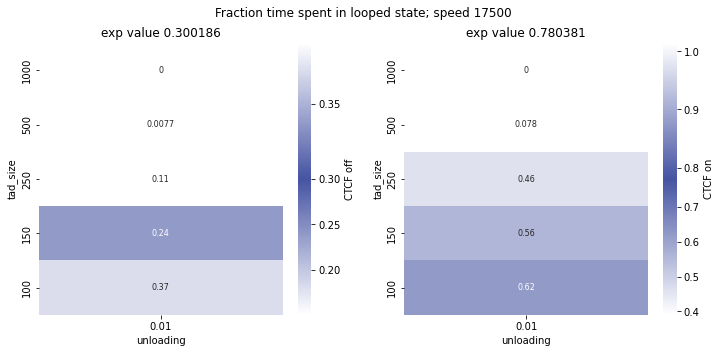

In [27]:
conditions = np.unique(
    [
        x[:-2].replace("ctcfon.", "").replace("ctcfoff.", "")
        for x in alldata.condition.unique()
    ]
)

time_spent_lst = []
for cond in conditions:
    subset_on = alldata[
        [
            cond.split("_")[0]
            + "_"
            + "ctcfon."
            + cond.split("_")[1]
            + "_"
            + cond.split("_")[2]
            in x
            for x in alldata.condition
        ]
    ].copy()
    subset_off = alldata[
        [
            cond.split("_")[0]
            + "_"
            + "ctcfoff."
            + cond.split("_")[1]
            + "_"
            + cond.split("_")[2]
            in x
            for x in alldata.condition
        ]
    ].copy()

    time = pd.DataFrame(
        [
            1 - subset_on.prediction.mean(),
            1 - subset_off.prediction.mean(),
        ],
        columns=["time"],
    )

    time["ctcf"] = ["on", "off"]
    time["type"] = cond
    time_spent_lst.append(time)
time_spent = pd.concat(time_spent_lst)

time_spent[["tad_size", "speed", "loading", "unloading"]] = (
    time_spent["type"]
    .replace("rad21on_", "", regex=True)
    .str.extract(r"([\d+]*)_([\d+]*)\.([\d]\.[\d+]*)\.([\d]\.[\d+]*)", expand=True)
)

speed = "17500"
ctcf_off = 0.300186
norm = mcolors.TwoSlopeNorm(vmin=ctcf_off * 0.5, vcenter=ctcf_off, vmax=ctcf_off * 1.3)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(
    time_spent[
        (time_spent.ctcf == "off")
        & (time_spent.speed == speed)
        & (time_spent.loading == "0.05")
    ]
    .replace({"tad_size": conversion_beads_to_kb})
    .pivot("tad_size", "unloading", "time")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF off"},
    norm=norm,
    annot_kws={"size": 8},
    ax=ax[0],
)
ax[0].set_title(f"exp value {ctcf_off}")

ctcf_on = 0.780381
norm = mcolors.TwoSlopeNorm(vmin=ctcf_on * 0.5, vcenter=ctcf_on, vmax=ctcf_on * 1.3)
sns.heatmap(
    time_spent[
        (time_spent.ctcf == "on")
        & (time_spent.speed == speed)
        & (time_spent.loading == "0.05")
    ]
    .replace({"tad_size": conversion_beads_to_kb})
    .pivot("tad_size", "unloading", "time")
    .sort_values(by=["tad_size"], ascending=False),
    annot=True,
    cmap=cmap,
    cbar_kws={"label": "CTCF on"},
    norm=norm,
    annot_kws={"size": 8},
    ax=ax[1],
)
ax[1].set_title(f"exp value {ctcf_on}")
plt.suptitle(f"Fraction time spent in looped state; speed {speed}")
plt.show()
pdf.savefig(fig)
pdf.close()